# Stokes

In [6]:
open femPoisson

## Introduction

[u,p] = STOKES(node,elem,pde,bdFlag) use continuous and piecewise
quadratic element for velocity u = [u1,u2] and continuous and piceswise
linear element for pressure p to approximate the Stokes equations

    -div(mu*grad u) + grad p = f in \Omega,
                     - div u = 0  in \Omega,
with 
    Dirichlet boundary condition        u = g_D  on \Gamma_D, 
    Neumann boundary condition du/dn - np = g_N  on \Gamma_N.

The mesh is given by node and elem and the boundary edge is given by
bdFlag. See meshdoc, bddoc for details. The data is given by the
structure pde which contains function handles f, g_D, g_N, and mu.

[u,p,edge,A,eqn,info] = STOKES(node,elem,pde,bdFlag,option) also
returns the edge structure of the mesh, the matrix A for the Laplace
operator, the eqn strcuture, and the info structure for solver information. 
  - eqn.AD: modified Laplace matrix
  - eqn.BD: modified negative divergence matrix
  - eqn.f:  vector f
  - eqn.g:  vector g

The solution [u,p] satisfy the saddle point problem:
  [AD BD'][u] = [f]
  [BD  0 ][p] = [g]

In the modified matrices AD, BD, the Dirichlet boundary condition of u
is built-into the equation as I_{\Gamma_D} u_D = g_D. The Neumann
boundary condition is built-into f by boundary integrals.

Users can chose other elements and specifies the solver options.
  - option.fem: various elements for Stokes equations
    * 'P2P1'    P2-P1 Taylor-Hood elements
    * 'P2P0'    P2-P0 elements
    * 'isoP2P0' P1(refined mesh)-P0 elements
    * 'isoP2P1' P1(refined mesh)-P1 elements
    * 'CRP0'    nonconforming P1 (CR)-P0 elements
    * 'Mini'    P1+B-P1 elements

  - option.solver: various solvers for Stokes system
    * 'direct'  the built in direct solver \ (mldivide)
    * 'uzawa'   inexact (augmented) Uzawa's method  
    * 'mg'      multigrid based on DGS smoother
    * 'blkdiag' block diagonal preconditioned MINRES
    * 'blktri'  block triangular preconditioned GMRES
The default setting is to use the direct solver for small size problems
and 'blkdiag' mehthod for large size problems.

## Variables

In [18]:
close all; 
clear variables;
%% Set up
maxIt = 4;
N = zeros(maxIt,1); 
h = zeros(maxIt,1);
erru = zeros(maxIt,1); 
errp = zeros(maxIt,1);

%% Generate initial mesh
[node,elem] = squaremesh([0 1 0 1], 0.25);
bdFlag = setboundary(node,elem,'Dirichlet');

%% PDE and options
pde = Stokesdata1;
% pde = Stokesdata3;

In [19]:
%% Generate initial mesh
[node,elem] = squaremesh([0 1 0 1], 0.25);
bdFlag = setboundary(node,elem,'Dirichlet');

%% PDE and options 
pde = Stokesdata1; 
% pde = Stokesdata3; 

In [1]:
help 

  DOFP2 dof structure for P2 element.
 
   [elem2dof,edge,bdDof] = DOFP2(elem) constructs the dof structure for the
   quadratic element based on a triangle. elem2dof(t,i) is the global index
   of the i-th dof of the t-th element. Each triangle contains 6 dofs which
   are organized according to the order of nodes and edges, i.e.
   elem2dof(t,1:3) is the pointer to dof on nodes and elem2dof(t,4:6) to
   three edges. The i-th edge is opposited to the i-th vertex.
 
   See also dof3P2.
  
   Documentation: <a href="matlab:ifem PoissonP2femrate">Quadratic Element
   for Poisson Equation in 2D</a>
 
  Copyright (C) Long Chen. See COPYRIGHT.txt for details.




## Process

In [20]:
if ~exist('option','var'), option = []; end

t = cputime;
%% Construct Data Structure
[elem2dof,edge,bdDof] = dofP2(elem);
N = size(node,1);  NT = size(elem,1);  Nu = N+size(edge,1);  Np = N;

%% Compute geometric quantities and gradient of local basis
[Dlambda,area] = gradbasis(node,elem);

%% Assemble stiffness matrix for Laplace operator
% generate sparse pattern
ii = zeros(21*NT,1); jj = zeros(21*NT,1); 
index = 0;
for i = 1:6
    for j = i:6
        ii(index+1:index+NT) = double(elem2dof(:,i)); 
        jj(index+1:index+NT) = double(elem2dof(:,j));  
        index = index + NT;
    end
end
% quadrature points
if ~isfield(pde,'nu'), pde.nu = []; end
if ~isfield(option,'quadorder')
    % constant viscosity
    option.quadorder = 2;        % default order
    if ~isempty(pde.nu) && isnumeric(pde.nu) % numerical viscosity
        option.quadorder = 3;    % exact for linear diffusion coefficient
    end
end
[lambda, w] = quadpts(option.quadorder);
nQuad = size(lambda,1);
% compute non-zeros
sA = zeros(21*NT,nQuad);
for p = 1:nQuad
    % Dphi at quadrature points
    Dphip(:,:,6) = 4*(lambda(p,1)*Dlambda(:,:,2)+lambda(p,2)*Dlambda(:,:,1));
    Dphip(:,:,5) = 4*(lambda(p,3)*Dlambda(:,:,1)+lambda(p,1)*Dlambda(:,:,3));
    Dphip(:,:,4) = 4*(lambda(p,2)*Dlambda(:,:,3)+lambda(p,3)*Dlambda(:,:,2));
    Dphip(:,:,1) = (4*lambda(p,1)-1).*Dlambda(:,:,1);            
    Dphip(:,:,2) = (4*lambda(p,2)-1).*Dlambda(:,:,2);            
    Dphip(:,:,3) = (4*lambda(p,3)-1).*Dlambda(:,:,3);            
    index = 0;
    for i = 1:6
        for j = i:6
            Aij = 0;
            if isempty(pde.nu) || isnumeric(pde.nu)
                Aij = Aij + w(p)*dot(Dphip(:,:,i),Dphip(:,:,j),2);
            else
                pxy = lambda(p,1)*node(elem(:,1),:) ...
                    + lambda(p,2)*node(elem(:,2),:) ...
                    + lambda(p,3)*node(elem(:,3),:);
                Aij = Aij + w(p)*dot(Dphip(:,:,i),Dphip(:,:,j),2).*pde.d(pxy);
            end
            if ~isempty(pde.nu) && (pde.nu~=1)
                Aij = pde.nu*Aij;
            end
            Aij = Aij.*area;
            sA(index+1:index+NT,p) = Aij;
            index = index + NT;
        end
    end
end
sA = sum(sA,2);
% assemble the matrix
diagIdx = (ii == jj);upperIdx = ~diagIdx;
A = sparse(ii(diagIdx),jj(diagIdx),sA(diagIdx),Nu,Nu);
AU = sparse(ii(upperIdx),jj(upperIdx),sA(upperIdx),Nu,Nu);
A = A + AU + AU';
A = blkdiag(A,A);
clear Aij ii jj sA

%% Assemble the matrix for divergence operator
Dx = sparse(Np,Nu);
Dy = sparse(Np,Nu);
[lambda, w] = quadpts(2); % (div(P2), P1) is P2
nQuad = size(lambda,1);
for p = 1:nQuad
    % Dphi at quadrature points
    Dphip(:,:,1) = (4*lambda(p,1)-1).*Dlambda(:,:,1);            
    Dphip(:,:,2) = (4*lambda(p,2)-1).*Dlambda(:,:,2);            
    Dphip(:,:,3) = (4*lambda(p,3)-1).*Dlambda(:,:,3);            
    Dphip(:,:,4) = 4*(lambda(p,2)*Dlambda(:,:,3)+lambda(p,3)*Dlambda(:,:,2));
    Dphip(:,:,5) = 4*(lambda(p,3)*Dlambda(:,:,1)+lambda(p,1)*Dlambda(:,:,3));
    Dphip(:,:,6) = 4*(lambda(p,1)*Dlambda(:,:,2)+lambda(p,2)*Dlambda(:,:,1));    
    for i = 1:6 
        for j = 1:3
            Dxij = 0;
            Dyij = 0;
            Dxij = Dxij + w(p)*Dphip(:,1,i).*lambda(p,j);
            Dyij = Dyij + w(p)*Dphip(:,2,i).*lambda(p,j);
            Dx = Dx + sparse(elem(:,j),double(elem2dof(:,i)),Dxij.*area,Np,Nu);
            Dy = Dy + sparse(elem(:,j),double(elem2dof(:,i)),Dyij.*area,Np,Nu);
        end
    end
end
B = -[Dx Dy];
clear Dxij Dyij Dx Dy Dphip

%% Assemble right hand side
f1 = zeros(Nu,1);
f2 = zeros(Nu,1);
if ~isfield(option,'fquadorder')
    option.fquadorder = 4;   % default order
end
if ~isfield(pde,'f') || (isreal(pde.f) && (pde.f==0))
    pde.f = [];
end
if ~isempty(pde.f) 
    % quadrature points in the barycentric coordinate
    [lambda,weight] = quadpts(option.fquadorder);
    % basis values at quadrature points
    phi(:,1) = lambda(:,1).*(2*lambda(:,1)-1);
    phi(:,2) = lambda(:,2).*(2*lambda(:,2)-1);
    phi(:,3) = lambda(:,3).*(2*lambda(:,3)-1);
    phi(:,4) = 4*lambda(:,2).*lambda(:,3);
    phi(:,5) = 4*lambda(:,3).*lambda(:,1);
    phi(:,6) = 4*lambda(:,1).*lambda(:,2);
    nQuad = size(lambda,1);
    ft1 = zeros(NT,6);
    ft2 = zeros(NT,6);
    for p = 1:nQuad
        % quadrature points in the x-y coordinate
        pxy = lambda(p,1)*node(elem(:,1),:) ...
            + lambda(p,2)*node(elem(:,2),:) ...
            + lambda(p,3)*node(elem(:,3),:);
        % function values at quadrature points
        fp = pde.f(pxy);
        % evaluate fp outside.
        for j = 1:6
            ft1(:,j) = ft1(:,j) + fp(:,1).*phi(p,j)*weight(p);
            ft2(:,j) = ft2(:,j) + fp(:,2).*phi(p,j)*weight(p);
        end
    end
    ft1 = ft1.*repmat(area,1,6);
    ft2 = ft2.*repmat(area,1,6);
    f1 = accumarray(elem2dof(:),ft1(:),[Nu 1]);
    f2 = accumarray(elem2dof(:),ft2(:),[Nu 1]);
end
clear phi ft1 ft2


ans = 

  Patch with properties:

    FaceColor: [0.5000 0.9000 0.4500]
    FaceAlpha: 1
    EdgeColor: [0 0 0]
    LineStyle: '-'
        Faces: [32x3 double]
     Vertices: [25x3 double]

  Use GET to show all properties




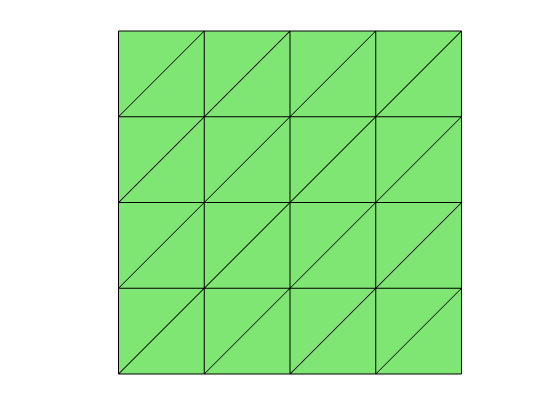

In [21]:
showmesh(node,elem)

## Getbd

In [22]:
g = zeros(Np,1);
u = zeros(2*Nu,1);    
p = zeros(Np,1);
ufreeDof = (1:Nu)';
pDof = (1:Np)';

if ~exist('bdFlag','var'), bdFlag = []; end
if ~isfield(pde,'g_D'), pde.g_D = []; end
if ~isfield(pde,'g_N'), pde.g_N = []; end
if ~isfield(pde,'g_R'), pde.g_R = []; end

%% Part 1: Find Dirichlet dof and modify the matrix
% Find Dirichlet boundary dof: fixedDof and pDof
isFixedDof = false(Nu,1);     
if ~isempty(bdFlag)       % case: bdFlag is not empty 
    elem2edge = elem2dof(:,4:6)-N;
    isDirichlet(elem2edge(bdFlag(:)==1)) = true;
    isFixedDof(edge(isDirichlet,:)) = true;   % nodes of all D-edges
    isFixedDof(N + find(isDirichlet')) = true;% dof on D-edges
    fixedDof = find(isFixedDof);
    ufreeDof = find(~isFixedDof);            
end
if isempty(bdFlag) && ~isempty(pde.g_D) && isempty(pde.g_N) && isempty(pde.g_R)
    fixedDof = bdDof; 
    isFixedDof(fixedDof) = true;
    ufreeDof = find(~isFixedDof);    
end
if isempty(fixedDof) % pure Neumann boundary condition
    % pde.g_N could be empty which is homogenous Neumann boundary condition
    fixedDof = 1;
    ufreeDof = (2:Nu)';    % eliminate the kernel by enforcing u(1) = 0;
end

% Modify the matrix
% Build Dirichlet boundary condition into the matrix AD by enforcing
% AD(fixedDof,fixedDof)=I, AD(fixedDof,ufreeDof)=0, AD(ufreeDof,fixedDof)=0.
% BD(:,fixedDof) = 0 and thus BD'(fixedDof,:) = 0.
bdidx = zeros(2*Nu,1); 
bdidx([fixedDof; Nu+fixedDof]) = 1;
Tbd = spdiags(bdidx,0,2*Nu,2*Nu);
T = spdiags(1-bdidx,0,2*Nu,2*Nu);
AD = T*A*T + Tbd;
BD = B*T;

%% Part 2: Find boundary edges and modify the right hand side f and g
% Find boundary edges: Neumann and Robin
Neumann = []; Robin = []; %#ok<*NASGU>
if ~isempty(bdFlag)
    isNeumann(elem2edge((bdFlag(:)==2)|(bdFlag(:) == 3))) = true;
    isRobin(elem2edge(bdFlag(:)==3)) = true;
    Neumannidx = find(isNeumann);        
    Neumann   = edge(isNeumann,:);
    Robin     = edge(isRobin,:);
end
if isempty(bdFlag) && (~isempty(pde.g_N) || ~isempty(pde.g_R))
    % no bdFlag, only pde.g_N or pde.g_R is given in the input
    Neumann = edge(bdDof>N,:);
    if ~isempty(pde.g_R)
        Robin = Neumann;
    end
end

% Neumann boundary condition
if ~isempty(pde.g_N) && ~isempty(Neumann) && ~(isnumeric(pde.g_N) && (pde.g_N == 0))
    [lambda,w] = quadpts1(3);
    nQuad = size(lambda,1);
    % quadratic bases (1---3---2)
    bdphi(:,1) = (2*lambda(:,1)-1).*lambda(:,1);
    bdphi(:,2) = (2*lambda(:,2)-1).*lambda(:,2);
    bdphi(:,3) = 4*lambda(:,1).*lambda(:,2);
    % length of edge
    ve = node(Neumann(:,1),:) - node(Neumann(:,2),:);
    edgeLength = sqrt(sum(ve.^2,2));
    % update RHS
    gex = zeros(size(Neumann,1),2);   % x-component
    gey = zeros(size(Neumann,1),2);   % y-component
    for pp = 1:nQuad
        pxy = lambda(pp,1)*node(Neumann(:,1),:)+lambda(pp,2)*node(Neumann(:,2),:);
        gp = pde.g_N(pxy);
        gex(:,1) = gex(:,1) + w(pp)*edgeLength.*gp(:,1)*bdphi(pp,1);
        gex(:,2) = gex(:,2) + w(pp)*edgeLength.*gp(:,1)*bdphi(pp,2);
        gey(:,1) = gey(:,1) + w(pp)*edgeLength.*gp(:,2)*bdphi(pp,1);
        gey(:,2) = gey(:,2) + w(pp)*edgeLength.*gp(:,2)*bdphi(pp,2);
        f1(N+Neumannidx) = f1(N+Neumannidx) + w(pp)*edgeLength.*gp(:,1)*bdphi(pp,3); % interior bubble
        f2(N+Neumannidx) = f2(N+Neumannidx) + w(pp)*edgeLength.*gp(:,2)*bdphi(pp,3); % interior bubble
    end
    f1(1:N) = f1(1:N) + accumarray(Neumann(:), gex(:),[N,1]);
    f2(1:N) = f2(1:N) + accumarray(Neumann(:), gey(:),[N,1]);
end
f = [f1; f2];
% The case non-empty Neumann but g_N=[] corresponds to the zero flux
% boundary condition on Neumann edges and no modification is needed.

% Dirichlet boundary conditions
if ~isempty(fixedDof) && ~isempty(pde.g_D) && ~(isnumeric(pde.g_D) && (pde.g_D == 0))
    u1 = zeros(Nu,1);
    u2 = zeros(Nu,1);
    idx = (fixedDof > N);              % index of edge dof
    uD = pde.g_D(node(fixedDof(~idx),:));  % bd value at vertex dofs    
    u1(fixedDof(~idx)) = uD(:,1);
    u2(fixedDof(~idx)) = uD(:,2);
    bdEdgeIdx = fixedDof(idx)-N;
    bdEdgeMid = (node(edge(bdEdgeIdx,1),:)+node(edge(bdEdgeIdx,2),:))/2;
    uD = pde.g_D(bdEdgeMid);         % bd values at middle points of edges
    u1(fixedDof(idx)) = uD(:,1);
    u2(fixedDof(idx)) = uD(:,2);
    u = [u1; u2]; % Dirichlet bd condition is built into u
    f = f - A*u;  % bring affect of nonhomgenous Dirichlet bd condition to
    g = g - B*u;  % the right hand side
    g = g - mean(g);         
    f(fixedDof) = u1(fixedDof);
    f(fixedDof+Nu) = u2(fixedDof);
end
% The case non-empty Dirichlet but g_D=[] corresponds to the zero Dirichlet
% boundary condition and no modification is needed.

% modfiy pressure dof for pure Dirichlet
if isempty(Neumann)
    pDof = (1:Np-1)';
end

ufreeDof = [ufreeDof; Nu+ufreeDof];

## Solving

In [23]:
%% Record assembeling time
assembleTime = cputime - t;
if ~isfield(option,'printlevel'), option.printlevel = 1; end
if option.printlevel >= 2
    fprintf('Time to assemble matrix equation %4.2g s\n',assembleTime);
end

%% Solve the system of linear equations
if isempty(ufreeDof), return; end
if isempty(option) || ~isfield(option,'solver')    % no option.solver
    if length(f)+length(g) <= 1e3  % Direct solver for small size systems
        option.solver = 'direct';
    else          % Multigrid-type  solver for large size systems
        option.solver = 'asmg';
    end
end
solver = option.solver;

% solve
switch solver
    case 'none'
        info = struct('solverTime',[],'itStep',0,'err',[],'flag',3,'stopErr',[]);        
    case 'direct'
        t = cputime;
        bigA = [AD, B'; ...
                B, sparse(Np,Np)];
        bigF = [f; g];
        bigu = [u; p];
        bigFreeDof = [ufreeDof; 2*Nu+pDof];
        bigu(bigFreeDof) = bigA(bigFreeDof,bigFreeDof)\bigF(bigFreeDof);
        u = bigu(1:2*Nu);
        p = bigu(2*Nu+1:end);
        residual = norm(bigF - bigA*bigu);
        info = struct('solverTime',cputime - t,'itStep',0,'err',residual,'flag',2,'stopErr',residual);     
    case 'mg'
%         option.tol = Np^(-2);        
        option.solver  = 'WCYCLE';
        [u(ufreeDof),p,info] = mgstokes(A(ufreeDof,ufreeDof),B(:,ufreeDof),f(ufreeDof),g,...
                                        u(ufreeDof),p,elem,ufreeDof,option);         
    case 'asmg'
        [u(ufreeDof),p,info] = asmgstokes(A(ufreeDof,ufreeDof),B(:,ufreeDof),f(ufreeDof),g,...
                                          u,p,node,elem,bdFlag,ufreeDof,option); 
end

%% Post-process
if length(pDof) ~= Np % p is unique up to a constant
    % impose the condition int(p)=0
    c = sum(mean(p(elem),2).*area)/sum(area);
    p = p - c;
end

%% Output
soln = struct('u',u,'p',p);
eqn = struct('A',AD,'B',BD,'Lap',A,'f',f,'g',g,...
             'edge',edge,'ufreeDof',ufreeDof,'pDof',pDof);
info.assembleTime = assembleTime;

In [24]:
% [node,elem,bdFlag] = uniformrefine(node,elem,bdFlag);
% % solve the equation
% [soln,eqn] = StokesP2P1(node,elem,bdFlag,pde);
% %     [soln,eqn] = StokesP2P0(node,elem,bdFlag,pde);
% %     [soln,eqn] = StokesisoP2P1(node,elem,bdFlag,pde);
% %     [soln,eqn] = StokesisoP2P0(node,elem,bdFlag,pde);
% %     [soln,eqn] = StokesCRP0(node,elem,bdFlag,pde);
% %     [soln,eqn] = StokesP1bP1(node,elem,bdFlag,pde);
uh = soln.u;
ph = soln.p;
% N(k) = length(uh)+length(ph);
% h(k) = 1./(sqrt(size(node,1))-1);

## Plotting convergence rates

In [ ]:
%% Plot convergence rates
% figure(2);
% showrateh2(h,erru,1,'-*','|u_I-u_h|_1',...
%            h,errp,1,'m-+','|| p-p_h||');

% fprintf('\n');
% disp('Table: Error')
% colname = {'#Dof','h','|u_I-u_h|_1','||p-p_h||'};
% disptable(colname,N,[],h,'%0.3e',erru,'%0.5e',errp,'%0.5e');
% figure;
% set(gcf,'Units','normal'); 
% set(gcf,'Position',[0.25,0.25,0.55,0.4]);

In [1]:
workspace